# Ad-Astra data

This notebook looks at the exports from Ad-Astra that we have access to. Each export includes all of the course (and non-course) scheduling of a semester.
Here I'm working with the data from the 2017 Fall semester.

## What is a "course"?
How do we represent a course at Olin?  
I've tried to list all of the "definable" dimensions that I could think of:
- a title  
  _e.g._ "Modeling and Simulation of the Physical World")
- an abbreviation of some sort  
  _e.g._ "ModSim"  
  This doesn't live in any database somewhere as far as I know, but it exists
  in most students' (and, I would imagine most community members') minds.
- professor(s)  
  A single one seems to be listed in the scheduling, but several often teach a course/section.
- NINJA(s)  
  Not represented anywhere that I know of, besides old pay stubs.
- students  
  This number can change throughout the semester, but will only decline after the
  Add period ends.
- room(s)
- credits
- classtimes
- expected hours in class/working with others/studying  
  I've seen this listed for _some_ courses in the course catalog
- course code(s)  
  Some courses have split credits, which are represented by multiple course codes.  
  ModSim, for example, is a 4-credit class split into 2 Math credits and 2 Science credits;
  it is represented as `MTH1111` and `SCI1111`.
- sections  
  Courses are often split up into multiple sections.  
  These **can** have:
  - different rooms
  - different times
  - different professors
  
  Generally they represent separate groups of students, but in some cases
  (mostly lab courses it seems) they can overlap with others (Everyone will have
  the main course as a single section, and then half will be in one lab
  section and half in another).  
  ModSim, as a first-year course, generally has
  3 sections across 3 classrooms (with 2 professors each in my year).

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Formatting Course Data

In [ ]:
fa17all = pd.read_excel('data/ad astra test fa17.xls')  # load from file
# convert time/date columns to time.date types
time_cols = ['Start Time', 'End Time']
time_pattern = '%I:%M %p'
for col in time_cols:
    # This is a bit of a beast. Ideally this would be a pd.datetime.time object,
    # but that doesn't seem to be well supported by other pandas operations.
    # Next best is a pd.timedelta, which could take the original string directly,
    # but doesn't like AM/PM (see https://github.com/pandas-dev/pandas/issues/18793).
    # What I settled on is to convert to datetime and subtract off the days
#     fa17all[col] = pd.to_timedelta(pd.to_datetime(fa17all[col], format=time_pattern).dt.strftime('%H:%M:%S'))
    fa17all[col] = pd.to_datetime(fa17all[col], format=time_pattern)
    fa17all[col] = fa17all[col] - pd.to_datetime(fa17all[col].dt.date)

date_cols = ['Start Date', 'End Date']
date_pattern = '%m/%d/%Y'
for col in date_cols:
    fa17all[col] = pd.to_datetime(fa17all[col], format=date_pattern)
# calculate times
# fa17all['length'] = pd.to_timedelta(fa17all['End Time']) - pd.to_timedelta(fa17all['Start Time']),
fa17all[::]

In [ ]:
# calculate lengths of coursetime
fa17all['Length'] = fa17all['End Time'] - fa17all['Start Time']
fa17all['Weekly Length'] = fa17all['Length'] * fa17all['Days'].str.len()  # total time per week

In [ ]:
# select only course scheduling
# could use a regex, but all others are "Olin College Students/Staff/Faculty")
fa17courses = fa17all[~fa17all['Course/Customer'].str.startswith('Olin College')]
fa17courses[::]

## Plotting/Merging

In [92]:
# plot courses by spacetime footprint
coursefootprint = fa17courses.groupby('Course/Customer', as_index=False)['Weekly Length'].agg(np.sum).sort_index(ascending=True)  # group, sum, and sort
# coursefootprint['Course/Customer'] = coursefootprint['Course/Customer'] / np.timedelta64(1,'h')  # convert to hours
# coursefootprint = coursefootprint.to_frame()
# coursefootprint.expanding
coursefootprint[::]

,Course/Customer,Weekly Length
0,AHSE0112,06:45:00
1,AHSE1122,06:40:00
2,AHSE1135,03:20:00
3,AHSE1155,06:40:00
4,AHSE1199,03:20:00
5,AHSE2515,03:20:00
6,AHSE2515A,03:20:00
7,AHSE3130,03:20:00
8,CIE2017B,07:00:00
9,ENGR1125,08:40:00


In [93]:
# merge with categorization data
categorization = pd.read_csv(
    'Class and Room Categorization - Classes Fall 2017.csv',  # just a csv export from the doc (could use Google Sheets csv publishing)
    usecols=range(13)
)
categorization.drop_duplicates(subset='Course Code', inplace=True)  # drop duplicate listings by course code

In [94]:
merged = pd.merge(
    left=coursefootprint,
    right=categorization[['Course Code','Course Title','Primary Category','Seconday Category']],  # yes, "Seconday"
    how='left',
    left_on='Course/Customer',
    right_on='Course Code',
    indicator=True,
    validate='one_to_many'
)
# merged.drop_duplicates(inplace=True)  #.groupby('Course Code', as_index=False)['Weekly Length'].agg(np.sum)
merged[::]

,Course/Customer,Weekly Length,Course Code,Course Title,Primary Category,Seconday Category,_merge
0,AHSE0112,06:45:00,AHSE0112,AHSE0112: The Olin Conductorless Orchestra,own thing,own thing,both
1,AHSE1122,06:40:00,AHSE1122,AHSE1122: The Wired Ensemble,PROJECT - BASED - digital,DISCUSSION,both
2,AHSE1135,03:20:00,AHSE1135,"AHSE1135: The Digital Eye: Photography, Vision...",PROJECT - BASED - 2d,DISCUSSION,both
3,AHSE1155,06:40:00,AHSE1155,AHSE1155: Identity from Mind & Brain: Who Am I...,DISCUSSION,NaN,both
4,AHSE1199,03:20:00,NaN,NaN,NaN,NaN,left_only
5,AHSE2515,03:20:00,AHSE2515,AHSE2515: Iterate,PROJECT - BASED - 3d,PROJECT - BASED - 2d,both
6,AHSE2515A,03:20:00,AHSE2515A,AHSE2515A: Iterate,PROJECT - BASED - 3d,PROJECT - BASED - 2d,both
7,AHSE3130,03:20:00,AHSE3130,AHSE3130: Advanced Digital Photography,PROJECT - BASED - 2d,DISCUSSION,both
8,CIE2017B,07:00:00,CIE2017B,Curriculum Innov Experiment: Quantitative Engi...,PROJECT - BASED - 3d,LECTURE,both
9,ENGR1125,08:40:00,ENGR1125,"ENGR1125: Introduction to Sensors, Instrumenta...",LAB,LECTURE,both


In [95]:
# merge with categorization data
def strip(text):
    try:
        return text.strip()
    except AttributeError:
        return text

def to_int(text):
    return int(text.strip('" '))

enrollment = pd.read_csv(
    'FA17_Enrollment.csv',  # just a csv export from the doc (could use Google Sheets csv publishing)
    usecols=[2,9],
    converters = {'Crs No' : strip, 'Registered Students' : to_int}
)
enrollment.drop_duplicates(subset='Crs No', inplace=True)  # drop duplicate listings by course code

In [96]:
merged = pd.merge(
    left=merged,
    right=enrollment,
    how='left',
    left_on='Course/Customer',
    right_on='Crs No',
    indicator='exists',
    validate='one_to_many'
)
merged[::]

,Course/Customer,Weekly Length,Course Code,Course Title,Primary Category,Seconday Category,_merge,Crs No,Registered Students,exists
0,AHSE0112,06:45:00,AHSE0112,AHSE0112: The Olin Conductorless Orchestra,own thing,own thing,both,AHSE0112,19,both
1,AHSE1122,06:40:00,AHSE1122,AHSE1122: The Wired Ensemble,PROJECT - BASED - digital,DISCUSSION,both,AHSE1122,10,both
2,AHSE1135,03:20:00,AHSE1135,"AHSE1135: The Digital Eye: Photography, Vision...",PROJECT - BASED - 2d,DISCUSSION,both,AHSE1135,14,both
3,AHSE1155,06:40:00,AHSE1155,AHSE1155: Identity from Mind & Brain: Who Am I...,DISCUSSION,NaN,both,AHSE1155,15,both
4,AHSE1199,03:20:00,NaN,NaN,NaN,NaN,left_only,AHSE1199,17,both
5,AHSE2515,03:20:00,AHSE2515,AHSE2515: Iterate,PROJECT - BASED - 3d,PROJECT - BASED - 2d,both,AHSE2515,26,both
6,AHSE2515A,03:20:00,AHSE2515A,AHSE2515A: Iterate,PROJECT - BASED - 3d,PROJECT - BASED - 2d,both,AHSE2515A,19,both
7,AHSE3130,03:20:00,AHSE3130,AHSE3130: Advanced Digital Photography,PROJECT - BASED - 2d,DISCUSSION,both,AHSE3130,7,both
8,CIE2017B,07:00:00,CIE2017B,Curriculum Innov Experiment: Quantitative Engi...,PROJECT - BASED - 3d,LECTURE,both,CIE2017B,35,both
9,ENGR1125,08:40:00,ENGR1125,"ENGR1125: Introduction to Sensors, Instrumenta...",LAB,LECTURE,both,ENGR1125,22,both


In [ ]:
category_colors = {  # map for category colors
    'PROJECT - BASED - 3d': '#1155cc',
    'PROJECT - BASED - 2d': '#3c78d8',
    'PROJECT - BASED - digital': '#6d9eeb',
    'LECTURE': '#e69138',
    'LAB': '#38761d',
    'NOT IN AC': '#cc0000',
    'DISCUSSION': '#674ea7'
}

### Pie Chart

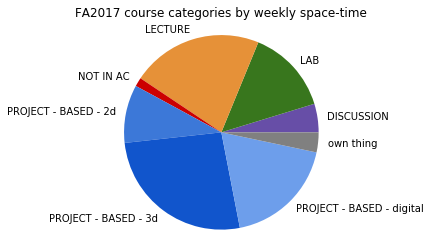

In [152]:
fa17category = merged.groupby('Primary Category', as_index=False)['Weekly Length'].agg(np.sum)

fig = plt.figure()
plt.pie(
    fa17category['Weekly Length'] / pd.Timedelta(1, unit='h'),
    labels=fa17category['Primary Category'],
    colors=[category_colors.get(category, 'grey') for category in fa17category['Primary Category']]
)
# plt.legend(fa17category['Primary Category'])
plt.title('FA2017 course categories by weekly space-time')
plt.axis('equal')
fig.patch.set_facecolor('white')

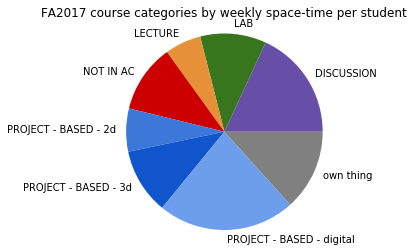

In [157]:
fa17category_normed = merged.groupby('Primary Category', as_index=False).agg({'Weekly Length':['sum'], 
                         'Registered Students':'sum'})
fig2 = plt.figure()
plt.pie(
    (fa17category_normed['Weekly Length']['sum'] / pd.Timedelta(1, unit='h'))/fa17category_normed['Registered Students']['sum'],
    labels=fa17category['Primary Category'],
    colors=[category_colors.get(category, 'grey') for category in fa17category['Primary Category']]
)
# plt.legend(fa17category['Primary Category'])
plt.title('FA2017 course categories by weekly space-time per student')
plt.axis('equal')
fig.patch.set_facecolor('white')

### Bar Chart

In [64]:
# parse out course title
import re
extractor = re.compile('^(?:(\w{3,4}\d{0,5}\w?)[:|/] )?(.*)$')
titles = [extractor.match(a).group(2) for a in merged['Course Title'].astype(str)]
# trim length of strings
max_len = 45
abbr_titles=[a[:max_len-3]+'...' if len(a) > max_len else a for a in titles]

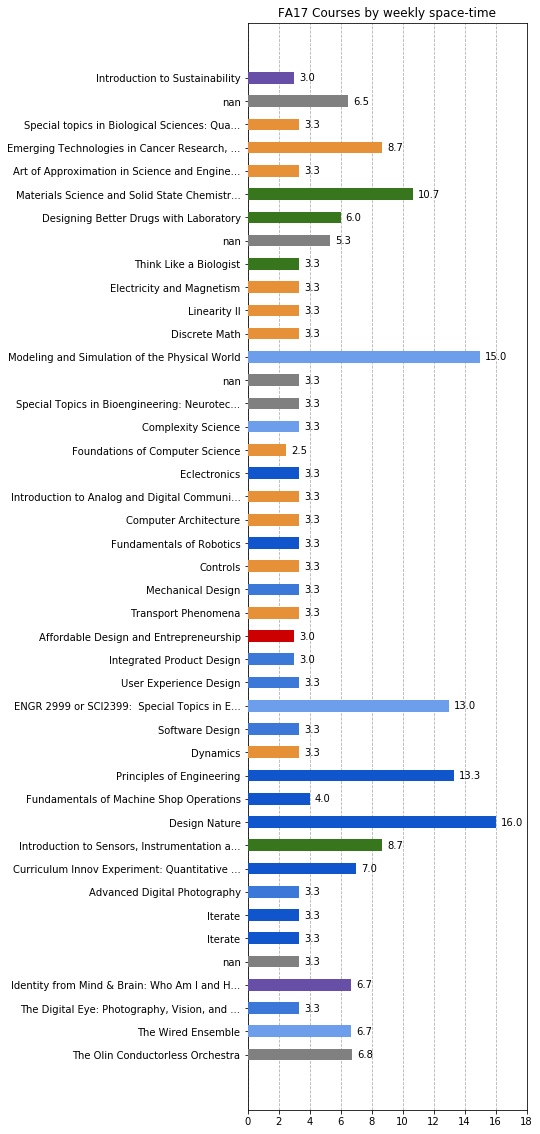

In [65]:
fig = plt.figure(figsize=(5,20))
bars = plt.barh(
#     tick_label=merged['Course Title'],
    tick_label=abbr_titles,
    y=np.arange(len(merged)),
    height=0.5,
    width=merged['Weekly Length'] / pd.Timedelta(1, unit='h'),
    align='center',
    color=[category_colors.get(category, 'grey') for category in merged['Primary Category']],  # default to grey if unknown category
    zorder=3
)

# add values to bar chart: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart#28931750
rects = bars.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5

    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha='left')                      # Horizontally align label differently for
                                    # positive and negative values.

# plt.xticks(rotation=90)
plt.xlim([0, 18])  # extend to fit labels
plt.grid(axis='x', linestyle='--', zorder=0)
plt.title('FA17 Courses by weekly space-time')
fig.patch.set_facecolor('white')

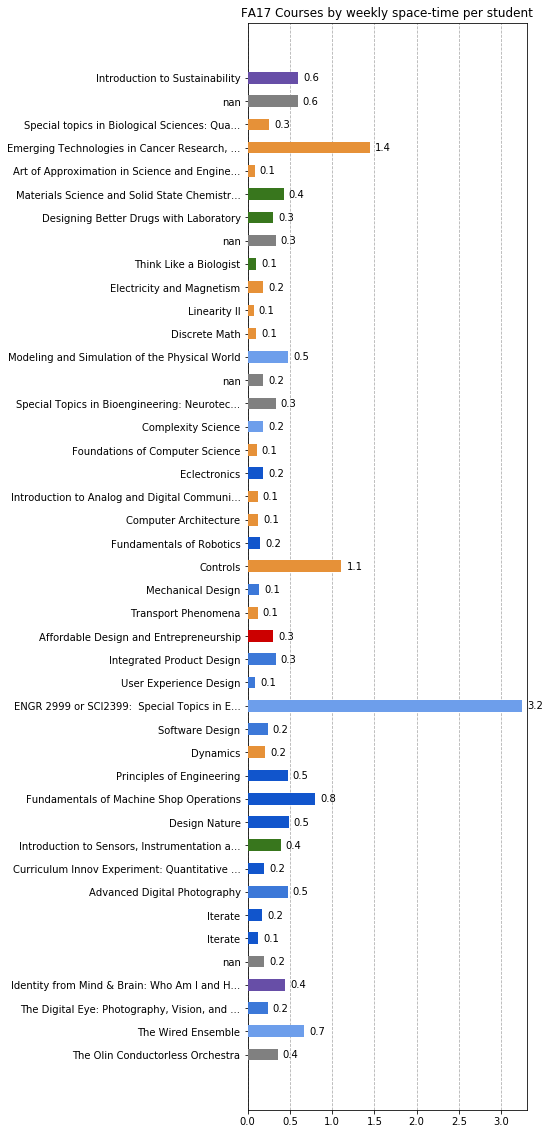

In [160]:
fig = plt.figure(figsize=(5,20))
bars = plt.barh(
#     tick_label=merged['Course Title'],
    tick_label=abbr_titles,
    y=np.arange(len(merged)),
    height=0.5,
    width=(merged['Weekly Length'] / pd.Timedelta(1, unit='h'))/merged['Registered Students'],
    align='center',
    color=[category_colors.get(category, 'grey') for category in merged['Primary Category']],  # default to grey if unknown category
    zorder=3
)

# add values to bar chart: https://stackoverflow.com/questions/28931224/adding-value-labels-on-a-matplotlib-bar-chart#28931750
rects = bars.patches
# For each bar: Place a label
for rect in rects:
    # Get X and Y placement of label from rect.
    x_value = rect.get_width()
    y_value = rect.get_y() + rect.get_height() / 2

    # Number of points between bar and label. Change to your liking.
    space = 5

    # Use X value as label and format number with one decimal place
    label = "{:.1f}".format(x_value)

    # Create annotation
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(space, 0),          # Horizontally shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        va='center',                # Vertically center label
        ha='left')                      # Horizontally align label differently for
                                    # positive and negative values.

# plt.xticks(rotation=90)
plt.xlim([0, 3.3])  # extend to fit labels
plt.grid(axis='x', linestyle='--', zorder=0)
plt.title('FA17 Courses by weekly space-time per student')
fig.patch.set_facecolor('white')

In [66]:
pd.options.mode.chained_assignment = None

# aggregate courses by course code and section
fa17courses['Course-Section'] = fa17courses['Course/Customer']+'-'+fa17courses['Section']
fa17_rcgroup = fa17courses.groupby(['Room','Title'])
fa17_courses_group = fa17courses.groupby(['Course/Customer','Section','Room'])

fa17_rc = fa17_courses_group['Weekly Length'].agg(np.sum)  # this returns a MultiIndex type